# 股指期货跨期套利策略探索

李林轩 202506

跨期套利是指在同一市场中利用标的相同、交割月份不同的期货合约进行长短期套利的策略，其本质上是一种风险对冲。股指期货跨期套利是指同时买入和卖出同一品种但不同交割月份的股指期货合约，以期在未来两种不同交割月份的期货合约价格涨幅不一致时，进而对冲合约获取利润。

股指期货各个合约对应的标的均为股票指数，存在一定的长期相关性。实际当中，由于现金交割、季节性特征不明显等特点，股指期货跨期套利的机会主要集中在股指期货移仓换季时，同时当存在指数分红预期、合约流动性、市场情绪等因素进，各个合约常常出现收益率的背离，在极端行情中也存在低风险套利机会。当期货深度贴水时、基差较高时，空头将主动移仓，从而压低次季合约价格，提高当季合约价格，导致跨期价差出现上行，从而产生跨期套利机会。同时当市场预期较为悲观时，远月合约会相对弱势，也会产生跨期套利机会。

下面先来观察股指期货数据：

In [24]:
# 导入需要的包
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

In [40]:
def process_futures_data(futures_type):
    """
    处理指定品种的期货价差数据
    
    参数:
        futures_type (str): 期货品种，如 'if', 'ih', 'ic', 'im'
    
    返回:
        pd.DataFrame: 处理后的价差数据
    """
    # 读取数据
    df0 = pd.read_csv(f'{futures_type.upper()}00.csv')
    df1 = pd.read_csv(f'{futures_type.upper()}01.csv')
    df2 = pd.read_csv(f'{futures_type.upper()}02.csv')
    df3 = pd.read_csv(f'{futures_type.upper()}03.csv')
    
    # 选择需要的列并重命名
    dfs = []
    for i, df in enumerate([df0, df1, df2, df3]):
        df_selected = df[['trade_date', 'close']].rename(
            columns={'close': f'close_{futures_type}{i}'}
        )
        dfs.append(df_selected)
    
    # 合并数据
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='trade_date', how='inner')
    
    # 计算价差
    for i in range(3):
        for j in range(i+1, 4):
            col_name = f'price_spread_{futures_type}{i}_{futures_type}{j}'
            merged_df[col_name] = merged_df[f'close_{futures_type}{i}'] - merged_df[f'close_{futures_type}{j}']
    
    # 转换日期格式
    merged_df['trade_date'] = pd.to_datetime(merged_df['trade_date'], format='%Y%m%d')
    
    return merged_df

def process_all_futures():
    """处理所有期货品种的数据"""
    futures_types = ['if', 'ih', 'ic', 'im']
    results = {}
    
    for ft in futures_types:
        print(f"正在处理{ft.upper()}数据...")
        try:
            df = process_futures_data(ft)
            results[ft] = df
            print(f"{ft.upper()}描述统计:")
            print(df.describe())
            # 保存到CSV
            df.to_csv(f'{ft}_spread.csv', index=False)
            print(f"{ft.upper()}数据已保存到{ft}_spread.csv\n")
        except Exception as e:
            print(f"处理{ft.upper()}数据时出错: {e}\n")
    
    return results

In [ ]:
# 导入各股指期货的本地数据，下载自Tushare。

# XX00 为本月合约（主力），XX01为次月合约（次主力）
df_if0 = pd.read_csv("data/IF00.csv")
df_if1 = pd.read_csv("data/IF01.csv")
df_if2 = pd.read_csv("data/IF02.csv")
df_if3 = pd.read_csv("data/IF03.csv")

df_ih0 = pd.read_csv("data/IH00.csv")
df_ih1 = pd.read_csv("data/IH01.csv")
df_ih2 = pd.read_csv("data/IH02.csv")
df_ih3 = pd.read_csv("data/IH03.csv")

df_ic0 = pd.read_csv("data/IC00.csv")
df_ic1 = pd.read_csv("data/IC01.csv")
df_ic2 = pd.read_csv("data/IC02.csv")
df_ic3 = pd.read_csv("data/IC03.csv")

df_im0 = pd.read_csv("data/IM00.csv")
df_im1 = pd.read_csv("data/IM01.csv")
df_im2 = pd.read_csv("data/IM02.csv")
df_im3 = pd.read_csv("data/IM03.csv")

In [ ]:
# 数据清洗，计算股指期货近远月价差，及其描述统计量
df0_selected = df_if0[['trade_date', 'close']].rename(columns={'close': 'close_if0'})
df1_selected = df_if1[['trade_date', 'close']].rename(columns={'close': 'close_if1'})
df2_selected = df_if2[['trade_date', 'close']].rename(columns={'close': 'close_if2'})
df3_selected = df_if3[['trade_date', 'close']].rename(columns={'close': 'close_if3'})
merged_df = pd.merge(df0_selected, df1_selected, on='trade_date', how='inner')
merged_df = pd.merge(merged_df, df2_selected, on='trade_date', how='inner')
merged_df = pd.merge(merged_df, df3_selected, on='trade_date', how='inner')
merged_df['price_spread_00_01'] = merged_df['close_if0'] - merged_df['close_if1']
merged_df['price_spread_00_02'] = merged_df['close_if0'] - merged_df['close_if2']
merged_df['price_spread_00_03'] = merged_df['close_if0'] - merged_df['close_if3']
merged_df['price_spread_01_02'] = merged_df['close_if1'] - merged_df['close_if2']
merged_df['price_spread_01_03'] = merged_df['close_if1'] - merged_df['close_if3']
merged_df['price_spread_02_03'] = merged_df['close_if2'] - merged_df['close_if3']
if_spread_df = merged_df[['trade_date', 'close_if0', 'close_if1', 'close_if2', 'close_if3', 'price_spread_00_01', 'price_spread_00_02', 'price_spread_00_03', 'price_spread_01_02', 'price_spread_01_03', 'price_spread_02_03']]
if_spread_df['trade_date'] = pd.to_datetime(if_spread_df['trade_date'], format='%Y%m%d')
print("IF描述统计")
print(if_spread_df.describe())
# if_spread_df.to_csv('if_spread.csv', index=False)


# df0_selected = df_ih0[['trade_date', 'close']].rename(columns={'close': 'close_ih0'})
# df1_selected = df_ih1[['trade_date', 'close']].rename(columns={'close': 'close_ih1'})
# merged_df = pd.merge(df0_selected, df1_selected, on='trade_date', how='inner')
# merged_df['price_spread'] = merged_df['close_ih0'] - merged_df['close_ih1']
# ih_spread_df = merged_df[['trade_date', 'close_ih0', 'close_ih1', 'price_spread']]
# ih_spread_df['trade_date'] = pd.to_datetime(if_spread_df['trade_date'], format='%Y%m%d')
# print("IH描述统计")
# print(ih_spread_df.describe())

# df0_selected = df_ic0[['trade_date', 'close']].rename(columns={'close': 'close_ic0'})
# df1_selected = df_ic1[['trade_date', 'close']].rename(columns={'close': 'close_ic1'})
# merged_df = pd.merge(df0_selected, df1_selected, on='trade_date', how='inner')
# merged_df['price_spread'] = merged_df['close_ic0'] - merged_df['close_ic1']
# ic_spread_df = merged_df[['trade_date', 'close_ic0', 'close_ic1', 'price_spread']]
# ic_spread_df['trade_date'] = pd.to_datetime(if_spread_df['trade_date'], format='%Y%m%d')
# print("IC描述统计")
# print(ic_spread_df.describe())

# df0_selected = df_im0[['trade_date', 'close']].rename(columns={'close': 'close_im0'})
# df1_selected = df_im1[['trade_date', 'close']].rename(columns={'close': 'close_im1'})
# merged_df = pd.merge(df0_selected, df1_selected, on='trade_date', how='inner')
# merged_df['price_spread'] = merged_df['close_im0'] - merged_df['close_im1']
# im_spread_df = merged_df[['trade_date', 'close_im0', 'close_im1', 'price_spread']]
# im_spread_df['trade_date'] = pd.to_datetime(if_spread_df['trade_date'], format='%Y%m%d')
# print("IM描述统计")
# print(im_spread_df.describe())


IF描述统计
                          trade_date    close_if0    close_if1    close_if2  \
count                           1999  1999.000000  1999.000000  1999.000000   
mean   2021-04-14 07:53:59.819910144  4006.193797  3996.563682  3979.704452   
min              2017-03-08 00:00:00  2962.200000  2962.400000  2964.200000   
25%              2019-03-25 12:00:00  3637.700000  3624.100000  3612.900000   
50%              2021-04-14 00:00:00  3896.600000  3892.000000  3873.600000   
75%              2023-05-08 12:00:00  4175.000000  4174.100000  4168.800000   
max              2025-05-30 00:00:00  5801.000000  5787.200000  5718.000000   
std                              NaN   556.606079   554.343334   546.671559   

         close_if3  price_spread_00_01  price_spread_00_02  \
count  1999.000000         1999.000000         1999.000000   
mean   3958.011206            9.630115           26.489345   
min    2958.400000          -39.400000          -51.400000   
25%    3597.600000           -0.8

/var/folders/4z/xbq1cg8j4dnf72216j7zqq2w0000gn/T/ipykernel_61204/2829052127.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/var/folders/4z/xbq1cg8j4dnf72216j7zqq2w0000gn/T/ipykernel_61204/2829052127.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/var/folders/4z/xbq1cg8j4dnf72216j7zqq2w0000gn/T/ipykernel_61204/2829052127.py:27: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/var/folders/4z/xbq1cg8j4dnf72216j7zqq2w0000gn/T/ipykernel_61204/2829052127.py:36: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/Users/lilinxuansmac/anaconda3/envs/Fin/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)
/Users/lilinxuansmac/anaconda3/envs/Fin/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: G

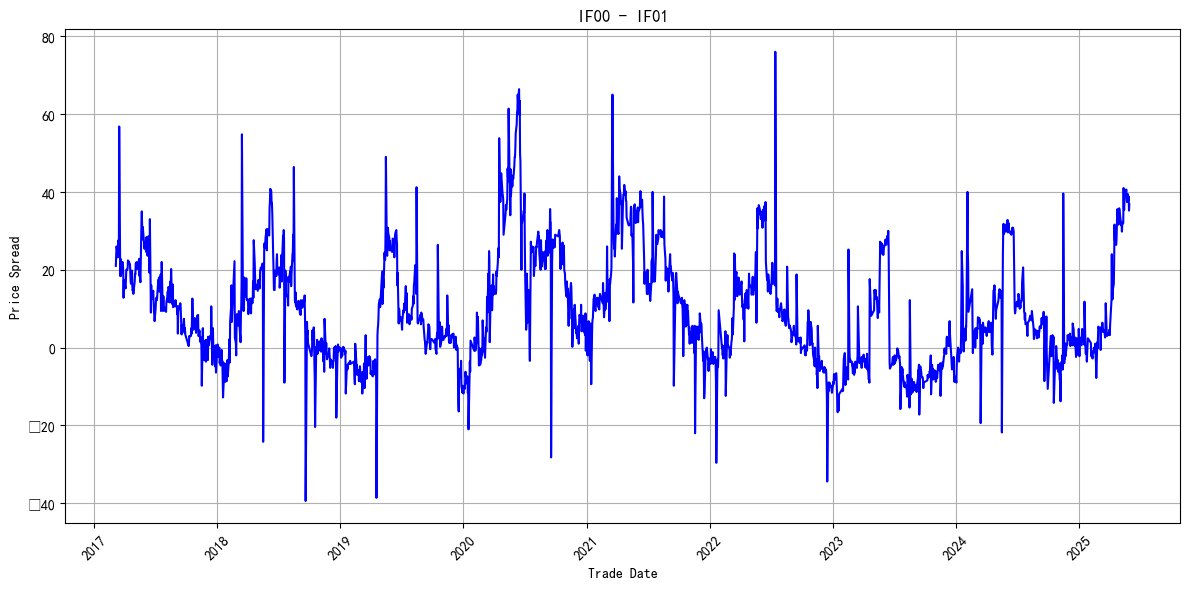

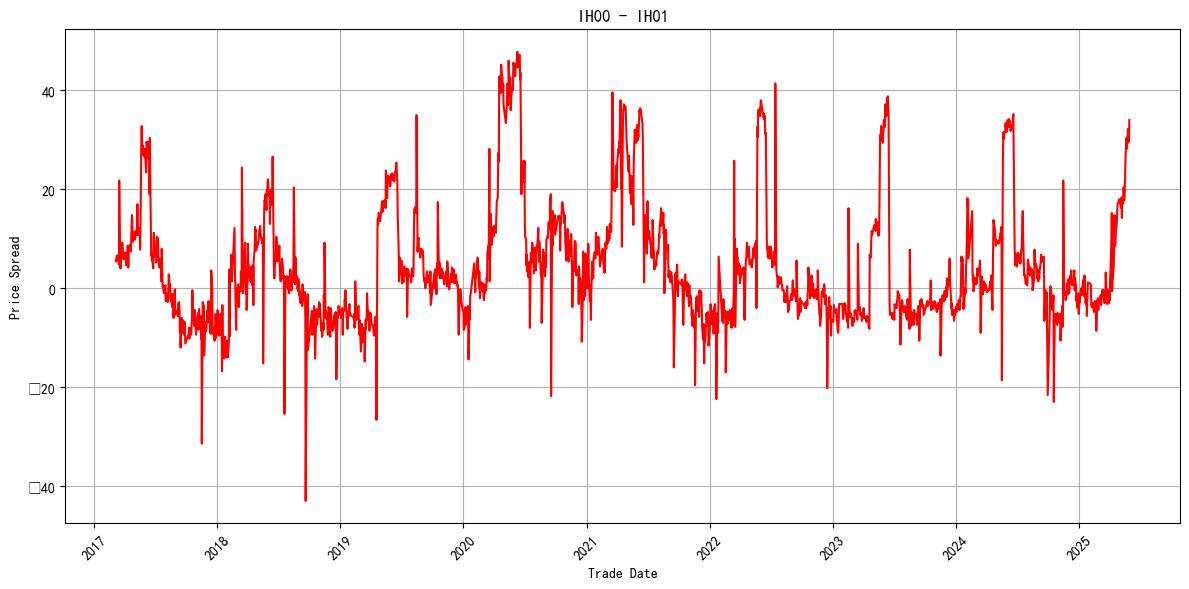

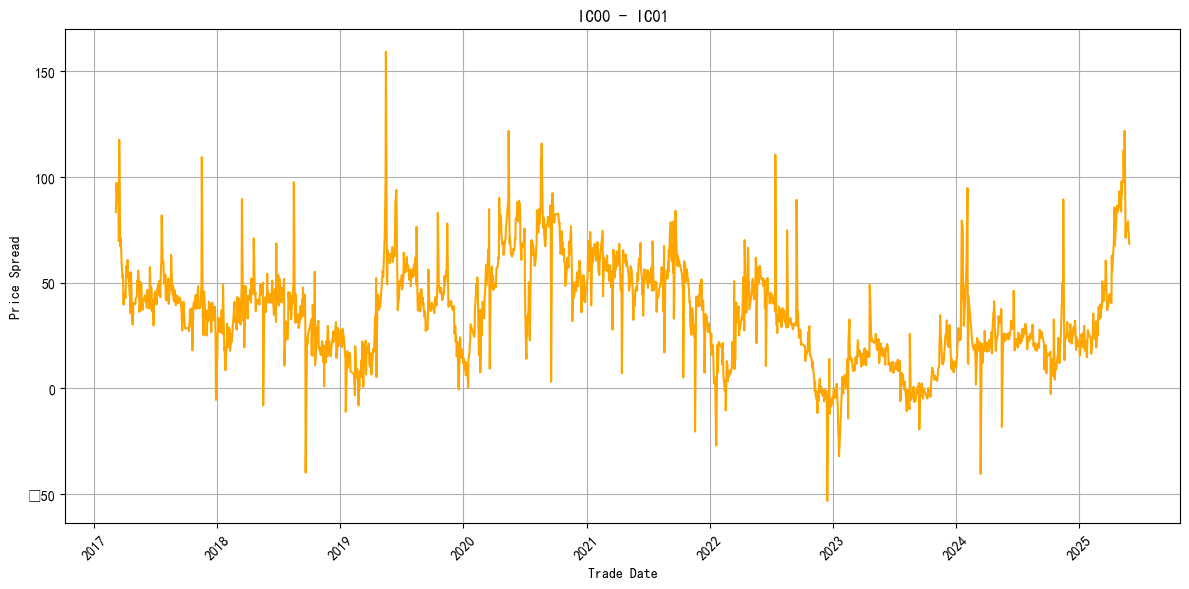

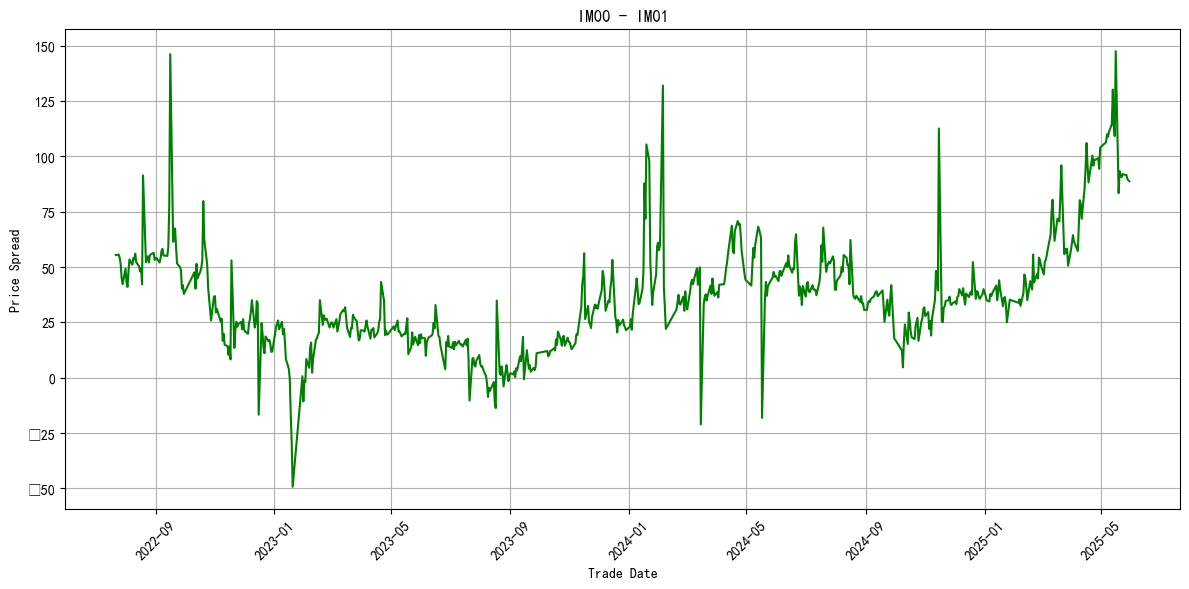

In [27]:
# 可视化-股指期货近远月价差
plt.figure(figsize=(12, 6)) # 设置图表大小
plt.plot(if_spread_df['trade_date'], if_spread_df['price_spread'],color="blue")
plt.title('IF00 - IF01')
plt.xlabel('Trade Date')
plt.ylabel('Price Spread')
plt.grid(True) # 添加网格
plt.xticks(rotation=45) # 旋转日期标签以提高可读性
plt.tight_layout()

plt.figure(figsize=(12, 6)) # 设置图表大小
plt.plot(ih_spread_df['trade_date'], ih_spread_df['price_spread'],color="red")
plt.title('IH00 - IH01')
plt.xlabel('Trade Date')
plt.ylabel('Price Spread')
plt.grid(True) # 添加网格
plt.xticks(rotation=45) # 旋转日期标签以提高可读性
plt.tight_layout()

plt.figure(figsize=(12, 6)) # 设置图表大小
plt.plot(ic_spread_df['trade_date'], ic_spread_df['price_spread'],color="orange")
plt.title('IC00 - IC01')
plt.xlabel('Trade Date')
plt.ylabel('Price Spread')
plt.grid(True) # 添加网格
plt.xticks(rotation=45) # 旋转日期标签以提高可读性
plt.tight_layout()

plt.figure(figsize=(12, 6)) # 设置图表大小
plt.plot(im_spread_df['trade_date'], im_spread_df['price_spread'],color="green")
plt.title('IM00 - IM01')
plt.xlabel('Trade Date')
plt.ylabel('Price Spread')
plt.grid(True) # 添加网格
plt.xticks(rotation=45) # 旋转日期标签以提高可读性
plt.tight_layout()

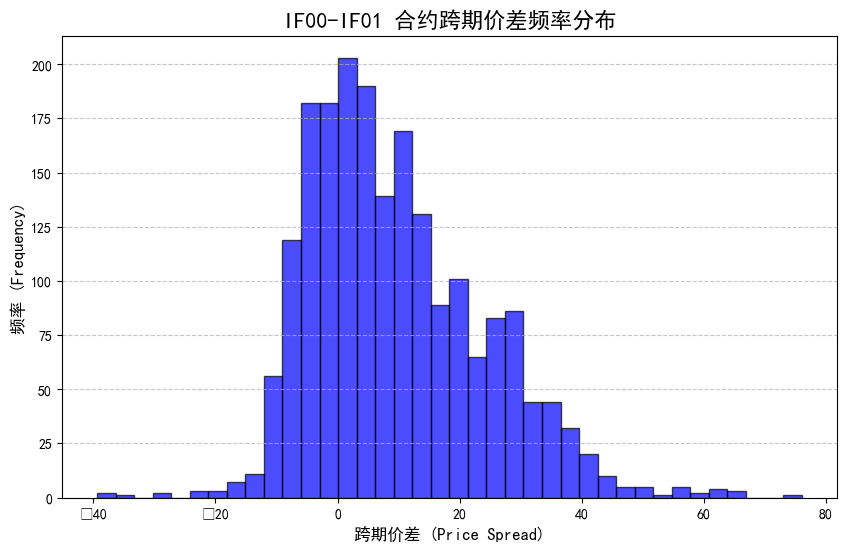

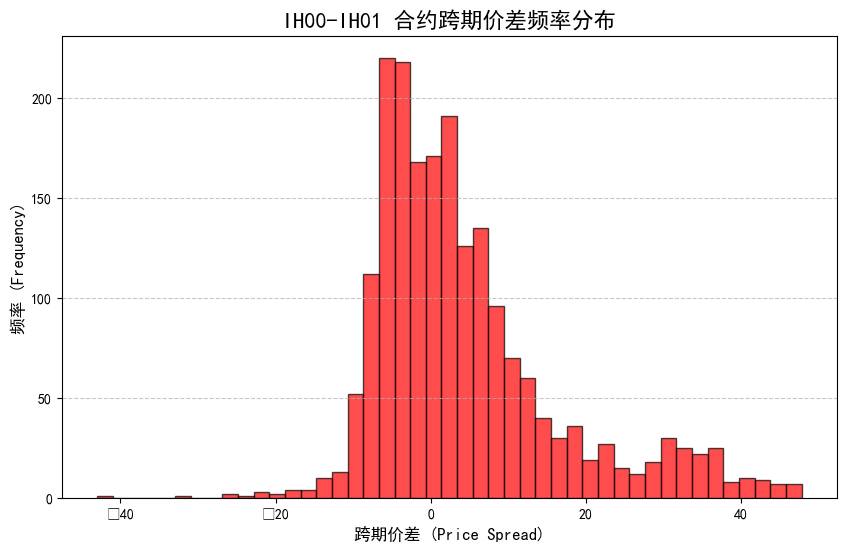

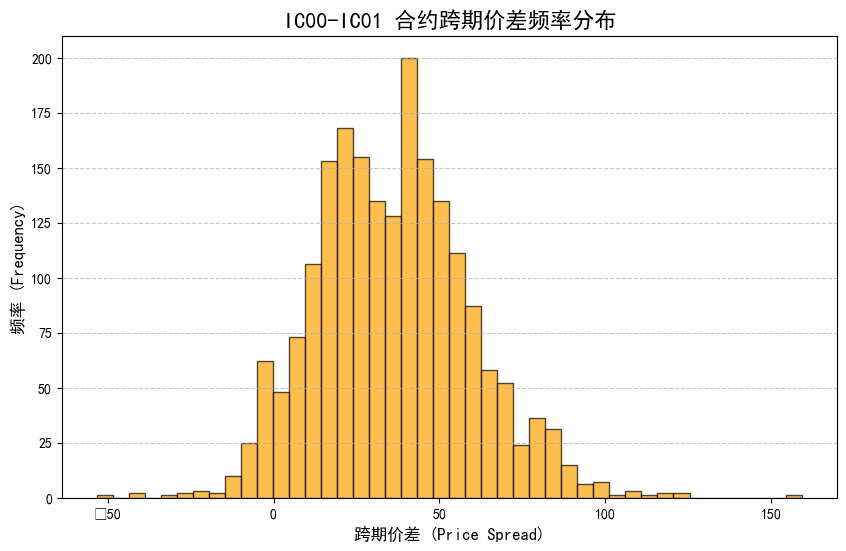

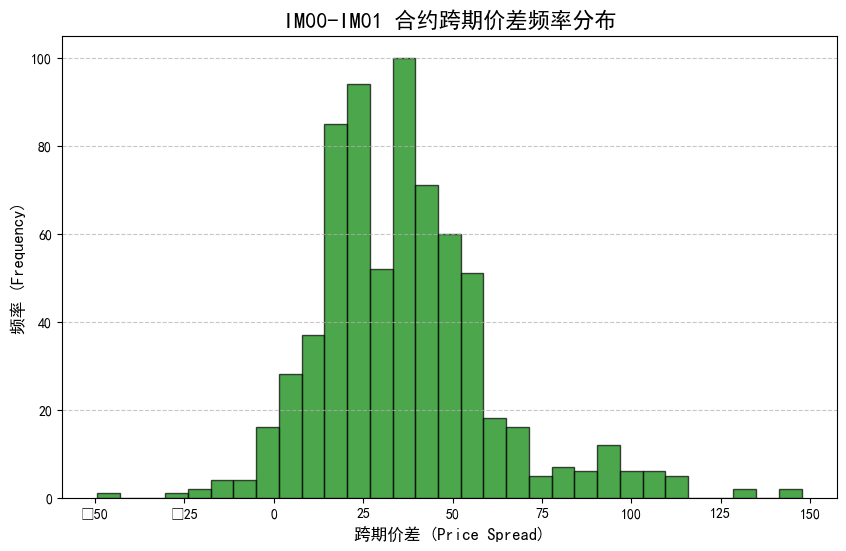

In [28]:
# 本月-次月合约跨期价差频率分布
plt.figure(figsize=(10, 6))
plt.hist(if_spread_df['price_spread'], bins='auto', color='blue', edgecolor='black', alpha=0.7)
plt.title('IF00-IF01 合约跨期价差频率分布', fontsize=16)
plt.xlabel('跨期价差 (Price Spread)', fontsize=12)
plt.ylabel('频率 (Frequency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.figure(figsize=(10, 6))
plt.hist(ih_spread_df['price_spread'], bins='auto', color='red', edgecolor='black', alpha=0.7)
plt.title('IH00-IH01 合约跨期价差频率分布', fontsize=16)
plt.xlabel('跨期价差 (Price Spread)', fontsize=12)
plt.ylabel('频率 (Frequency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.figure(figsize=(10, 6))
plt.hist(ic_spread_df['price_spread'], bins='auto', color='orange', edgecolor='black', alpha=0.7)
plt.title('IC00-IC01 合约跨期价差频率分布', fontsize=16)
plt.xlabel('跨期价差 (Price Spread)', fontsize=12)
plt.ylabel('频率 (Frequency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.figure(figsize=(10, 6))
plt.hist(im_spread_df['price_spread'], bins='auto', color='green', edgecolor='black', alpha=0.7)
plt.title('IM00-IM01 合约跨期价差频率分布', fontsize=16)
plt.xlabel('跨期价差 (Price Spread)', fontsize=12)
plt.ylabel('频率 (Frequency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

## 平稳/协整检验

ADF(Augmented Dickey-Fuller Test) 检验是一种单位根检验 (Unit Root Test)。单位根是导致序列非平稳的一个常见原因。

原假设 (H0)：时间序列具有单位根（即非平稳）。

备择假设 (H1)：时间序列没有单位根（即平稳或趋势平稳）。

如果检验结果的 p 值小于显著性水平（例如 0.05），则我们拒绝原假设，认为序列是平稳的。反之，如果 p 值较大，则不能拒绝原假设，认为序列可能是非平稳的。

In [29]:
# ADF检验平稳性
def perform_adf_test(series, series_name=""):
    """
    对时间序列执行 ADF 检验并打印结果。
    """
    print(f"\n--- 对 '{series_name}' 进行 ADF 检验 ---")
    # 删除 NaN 值，ADF 检验不能处理 NaN
    result = adfuller(series.dropna(), autolag='AIC')

    print(f'ADF 统计量: {result[0]}')
    print(f'p 值: {result[1]}')
    print('临界值:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("结论: 拒绝原假设 (H0)，数据是平稳的 (在 5% 的显著性水平下)。")
    else:
        print("结论: 未能拒绝原假设 (H0)，数据是非平稳的 (在 5% 的显著性水平下)。")
    return result

# adf_result_if = perform_adf_test(if_spread_df['close_if0'],"IF00收盘价")
# adf_result_if = perform_adf_test(if_spread_df['close_if1'],"IF01收盘价")
adf_result_if = perform_adf_test(if_spread_df['price_spread'], "IF跨期价差")
adf_result_ih = perform_adf_test(ih_spread_df['price_spread'], "IH跨期价差")
adf_result_ic = perform_adf_test(ic_spread_df['price_spread'], "IC跨期价差")
adf_result_im = perform_adf_test(im_spread_df['price_spread'], "IM跨期价差")


--- 对 'IF跨期价差' 进行 ADF 检验 ---
ADF 统计量: -4.659659680823957
p 值: 0.00010012986727234892
临界值:
	1%: -3.43363537003345
	5%: -2.862991296796771
	10%: -2.5675426088474738
结论: 拒绝原假设 (H0)，数据是平稳的 (在 5% 的显著性水平下)。

--- 对 'IH跨期价差' 进行 ADF 检验 ---
ADF 统计量: -5.6561981494544655
p 值: 9.608497110496202e-07
临界值:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156
结论: 拒绝原假设 (H0)，数据是平稳的 (在 5% 的显著性水平下)。

--- 对 'IC跨期价差' 进行 ADF 检验 ---
ADF 统计量: -3.9888530334544576
p 值: 0.0014700180426769705
临界值:
	1%: -3.4336370214482437
	5%: -2.862992025899885
	10%: -2.5675429970585153
结论: 拒绝原假设 (H0)，数据是平稳的 (在 5% 的显著性水平下)。

--- 对 'IM跨期价差' 进行 ADF 检验 ---
ADF 统计量: -2.8575049666752297
p 值: 0.05051745510202654
临界值:
	1%: -3.4399889432093325
	5%: -2.865793456189478
	10%: -2.5690350878361916
结论: 未能拒绝原假设 (H0)，数据是非平稳的 (在 5% 的显著性水平下)。
